# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline

# Config

In [3]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data'
SHAPE_FILE_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/map_data/taxi_zones/taxi_zones.shp'
LR_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/lr_result.parquet'
XGB_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/XGB_result.parquet'

PRED_RESULT_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/Pred_Result.csv'

start_date_test = '2023-04-01'
end_date_test = '2023-05-01'

# Load Data files

In [4]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    df = df.rename(columns={'real demand': 'count',
                   'predicted demand': 'pred_count'})
    return df

In [5]:
lr_rides_df = load_data(LR_PATH)
print(lr_rides_df.shape)
lr_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5429.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,4.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,1.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,2.0


In [6]:
xgb_rides_df = load_data(XGB_PATH)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5374.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,3.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,3.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,3.0


### Improved Data Bound Within Range: 2023-04-01 to 2023-04-30

For Model Evaluation

In [7]:
def df_time_bound(df):
    df['date'] = pd.to_datetime(df['date'])
    filtered_rides_df = df[(df['date'] >= start_date_test) & (
        df['date'] < end_date_test)]
    # Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
    filtered_rides_df = filtered_rides_df.sort_values(by='date')
    filtered_rides_df = filtered_rides_df.reset_index(drop=True)
    return filtered_rides_df

In [8]:
lr_rides_df = df_time_bound(lr_rides_df)
print(lr_rides_df.shape)
lr_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,4.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2682.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1413.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1820.0


In [9]:
xgb_rides_df = df_time_bound(xgb_rides_df)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,3.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2717.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1379.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1818.0


In [10]:
predictions_dict = {
    'baseline_last_week': None,
    'model_regression': None,
    'model_xgboost': None
}

In [11]:
predictions_dict['baseline_last_week'] = xgb_rides_df[['date', 'PULocationID',
                                                       'last_week_demand']].rename(columns={'last_week_demand': 'pred_count'})

In [12]:
predictions_dict['model_regression'] = lr_rides_df[[
    'date', 'PULocationID', 'pred_count']]

In [13]:
predictions_dict['model_xgboost'] = xgb_rides_df[[
    'date', 'PULocationID', 'pred_count']]

In [14]:
predictions_dict

{'baseline_last_week':            date  PULocationID  pred_count
 0    2023-04-01            27         1.0
 1    2023-04-01           180         3.0
 2    2023-04-01           164      2627.0
 3    2023-04-01           144      1486.0
 4    2023-04-01           140      1644.0
 ...         ...           ...         ...
 7855 2023-04-30            59         1.0
 7856 2023-04-30           176         1.0
 7857 2023-04-30            84         1.0
 7858 2023-04-30           136         1.0
 7859 2023-04-30             6         2.0
 
 [7860 rows x 3 columns],
 'model_regression':            date  PULocationID  pred_count
 0    2023-04-01            27        -0.0
 1    2023-04-01           180         4.0
 2    2023-04-01           164      2682.0
 3    2023-04-01           144      1413.0
 4    2023-04-01           140      1820.0
 ...         ...           ...         ...
 7855 2023-04-30            59         0.0
 7856 2023-04-30           176         0.0
 7857 2023-04-30           

# Report by Metrics

### Calculate metrics for all predictions model per all LocationIDs

In [15]:
PULocationIDs = xgb_rides_df['PULocationID'].unique()
PULocationIDs.sort()
metrics_all = []
for key in predictions_dict:
    for locationID in PULocationIDs:
        selected_df_model = predictions_dict[key][predictions_dict[key]
                                                  ['PULocationID'] == locationID]
        selected_df_actual = xgb_rides_df[xgb_rides_df['PULocationID'] == locationID]
        metric_mape = mean_absolute_percentage_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_mae = mean_absolute_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_rmse = mean_squared_error(
            selected_df_actual['count'], selected_df_model['pred_count'], squared=False)
        metrics_all.append({'PULocationID': locationID, 'Model': key, 'MAPE': metric_mape,
                           'MAE': metric_mae, 'RMSE': metric_rmse})


PULocationIDs_Metrics = pd.DataFrame(metrics_all)

In [16]:
print(PULocationIDs_Metrics.shape)
PULocationIDs_Metrics.head()

(786, 5)


,PULocationID,Model,MAPE,MAE,RMSE
0,1,baseline_last_week,0.302420,4.033333,5.076088
1,2,baseline_last_week,0.116667,0.133333,0.365148
2,3,baseline_last_week,0.707222,1.600000,1.932184
3,4,baseline_last_week,0.137036,19.200000,30.735430
4,5,baseline_last_week,0.435000,0.933333,1.183216


# Visualization

### Compare Models prediction vs. Last day count base on MAPE metric

In [17]:
def plot_model_metric(df, sorted_df, lower, upper, metrics):
    PULocationIDs_Metrics_Selected = sorted_df[sorted_df['PULocationID'].isin(
        df.iloc[lower:upper, 0])]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype(
        'str')
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=PULocationIDs_Metrics_Selected,
                 x='PULocationID', y=metrics, hue='Model')
    plt.xticks(rotation=90)
    plt.title(f'Show Metric {metrics} For Location Id')
    plt.show()

In [18]:
# Prepare data for sorting based on demands count
xgb_rides_df_sorted = xgb_rides_df.groupby('PULocationID')[['count']].mean(
).sort_values('count', ascending=False).reset_index()
dummy = pd.Series(xgb_rides_df_sorted['PULocationID']).to_frame()
PULocationIDs_Metrics_sorted = pd.merge(dummy, PULocationIDs_Metrics,
                                        on='PULocationID', how='left')

#### High Demand

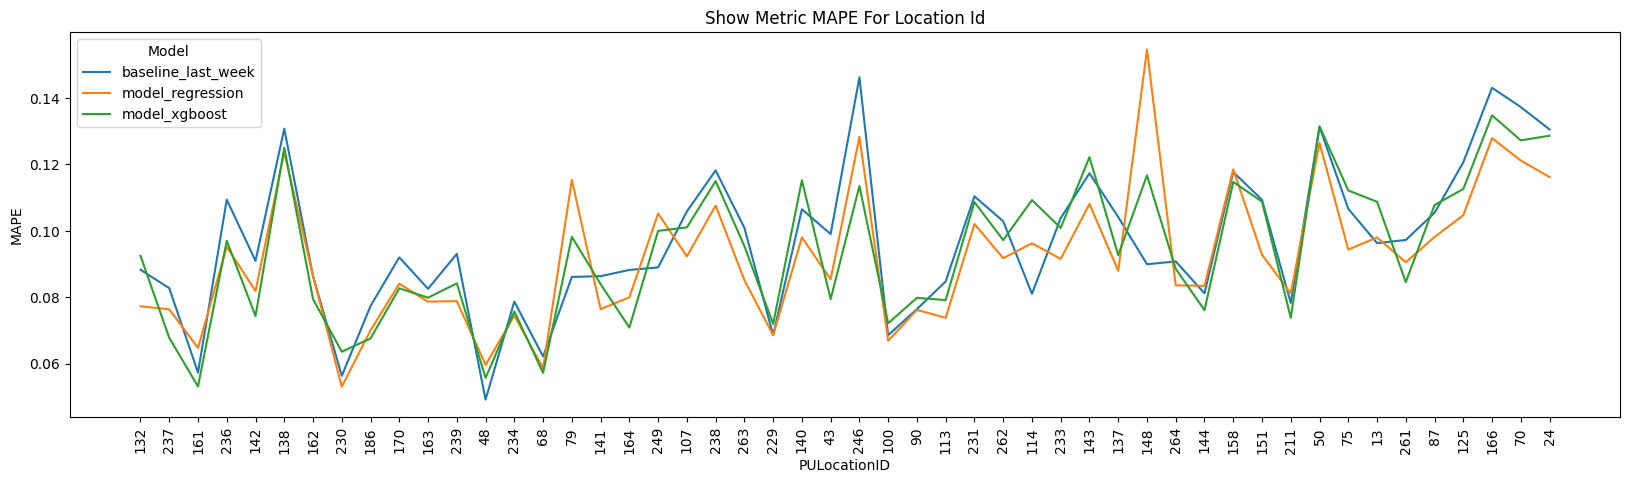

In [19]:
plot_model_metric(xgb_rides_df_sorted,
                  PULocationIDs_Metrics_sorted, 0, 50, 'MAPE')

#### Mid Demand

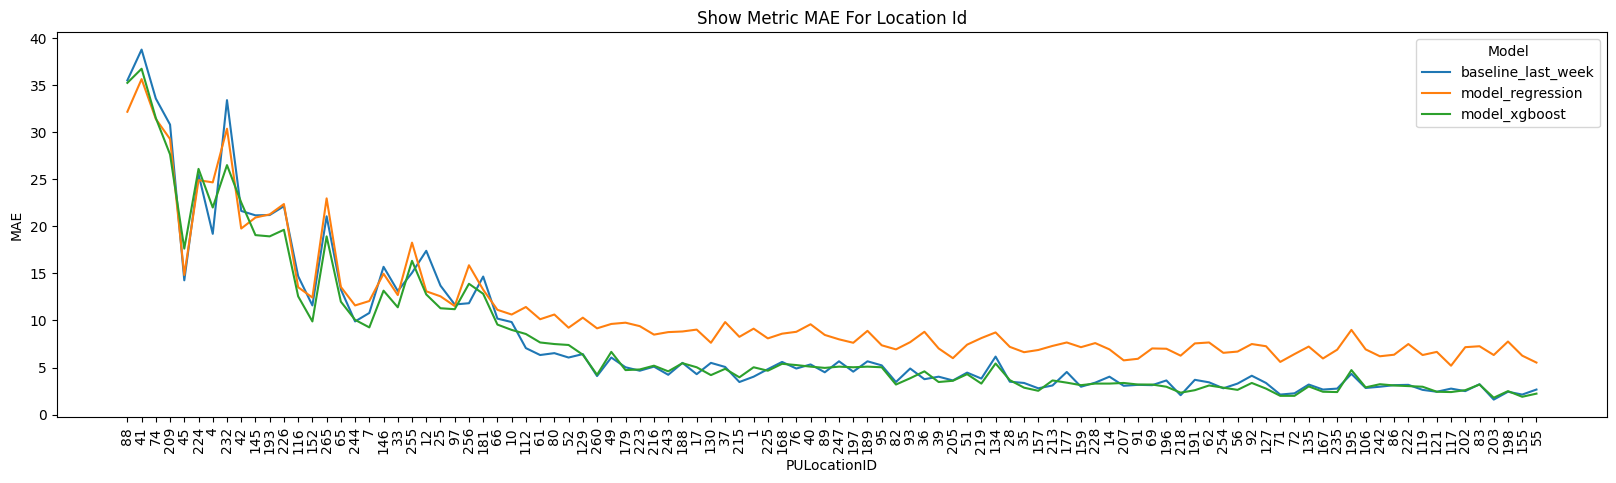

In [20]:
plot_model_metric(xgb_rides_df_sorted,
                  PULocationIDs_Metrics_sorted, 50, 150, 'MAE')

#### Low Demand

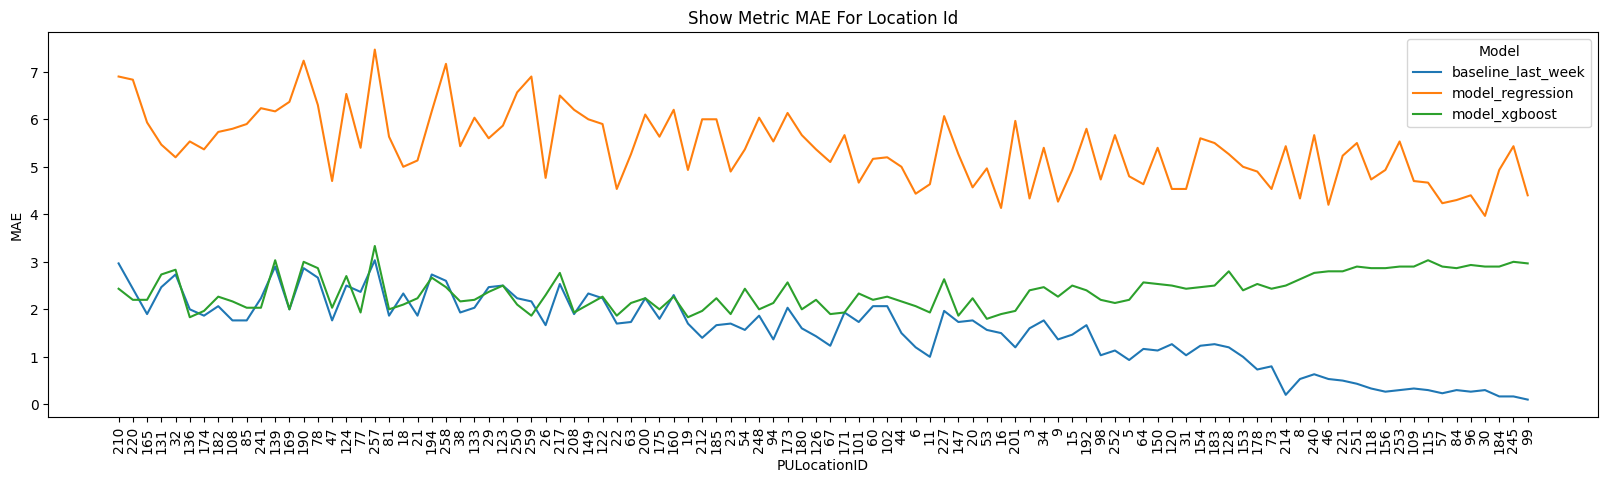

In [21]:
plot_model_metric(xgb_rides_df_sorted,
                  PULocationIDs_Metrics_sorted, 150, 250, 'MAE')

### Compare Models predicion vs. Last day count based on actual count

In [22]:
def plot_model_actual(actual_data, pred_dict, lower_bound=0, upper_bound=262):
    selected_df_model = actual_data.groupby('PULocationID')[['count']].mean(
    ).sort_values('count', ascending=False).reset_index()

    selected_df_model = selected_df_model.iloc[lower_bound:upper_bound]

    plt.figure(figsize=(15, 5))
    plt.scatter(selected_df_model.index,
                selected_df_model['count'], label="Actual", color='red', s=15)
    for key in pred_dict:
        sorted_df = pd.merge(
            selected_df_model['PULocationID'], pred_dict[key], on='PULocationID', how='left')
        sorted_df = sorted_df.groupby('PULocationID')[['pred_count']].mean(
        ).sort_values('pred_count', ascending=False).reset_index()
        plt.plot(selected_df_model.index, sorted_df['pred_count'], label=key)

    plt.xticks(selected_df_model.index,
               selected_df_model['PULocationID'], rotation=90)

    plt.legend()
    plt.xlabel('PULocationID')
    plt.ylabel('Counts')
    plt.title('Demand count compare models predictions vs. actual')

    plt.show()

#### High Demand

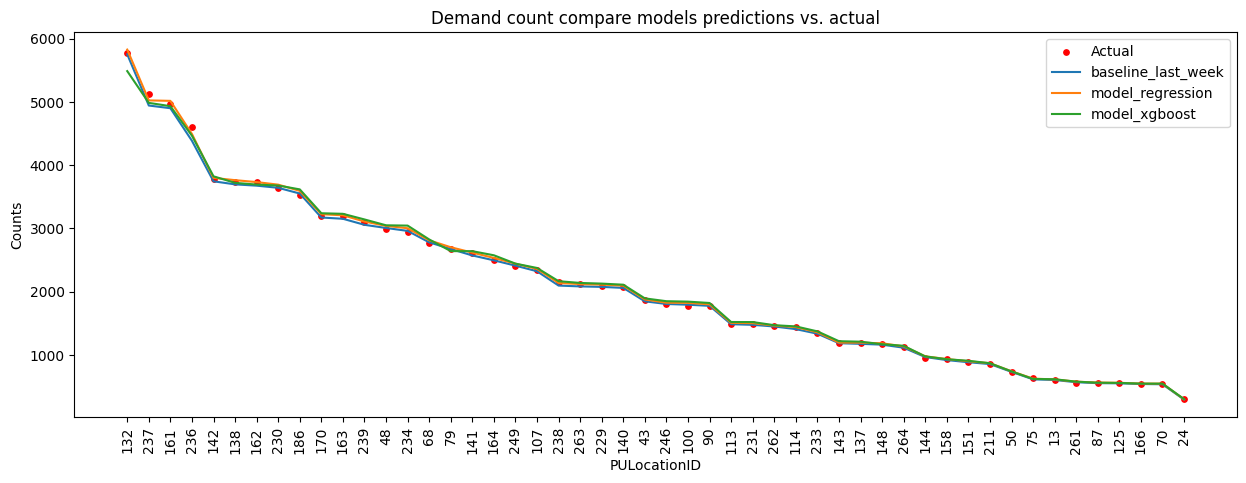

In [23]:
plot_model_actual(xgb_rides_df, predictions_dict, 0, 50)

#### Mid Demand

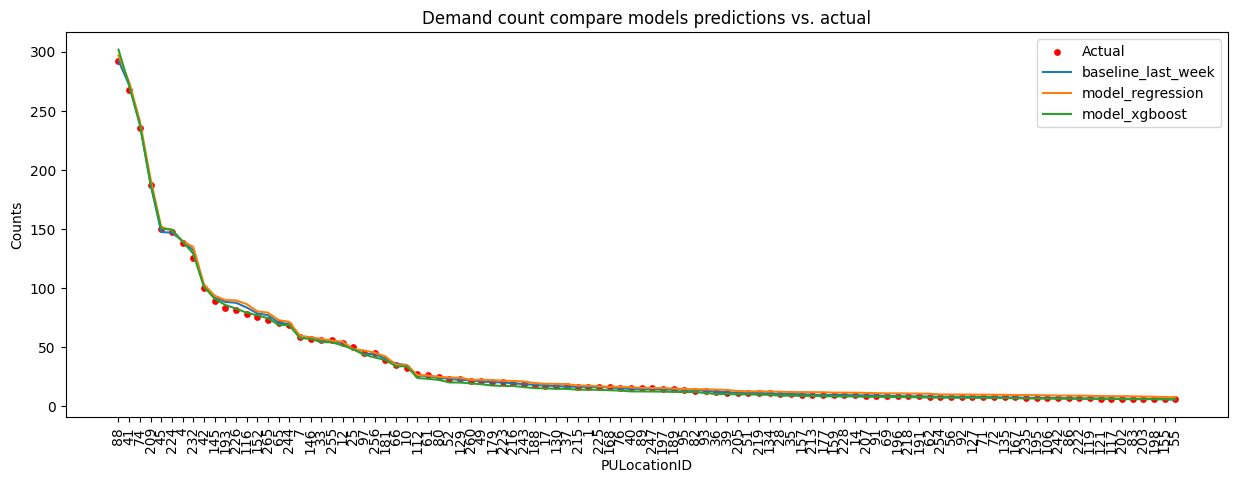

In [24]:
plot_model_actual(xgb_rides_df, predictions_dict, 50, 150)

#### Low Demand

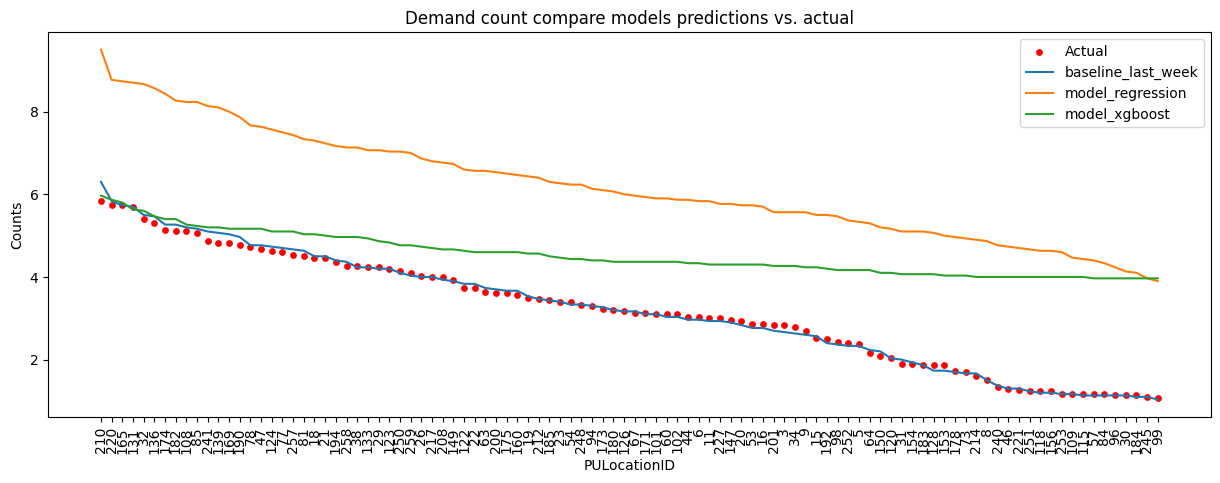

In [25]:
plot_model_actual(xgb_rides_df, predictions_dict, 150, 250)

# Model prediction results in metrics

Metrics: MAPE, MAE, RMSE

In [26]:
def caculate_metrics(df, sorted_df, lower=0, upper=266):
    PULocationIDs_Metrics_Selected = sorted_df[sorted_df['PULocationID'].isin(
        df.iloc[lower:upper, 0])]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype(
        'str')
    predictions_result = []
    for key in predictions_dict:
        metric_mape = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['MAPE'].mean(
        )
        metric_mae = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['MAE'].mean(
        )
        metric_rmse = PULocationIDs_Metrics_Selected[PULocationIDs_Metrics_Selected['Model'] == key]['RMSE'].mean(
        )
        predictions_result.append({'Model': key, f"MAPE_{lower}-{upper}": metric_mape, f"MAE_{lower}-{upper}": metric_mae,
                                   f"RMSE_{lower}-{upper}": metric_rmse})
    return predictions_result

#### High Demand

In [27]:
df1 = pd.DataFrame(caculate_metrics(
    xgb_rides_df_sorted, PULocationIDs_Metrics_sorted, 0, 50))

#### Mid Demand

In [28]:
df2 = pd.DataFrame(caculate_metrics(
    xgb_rides_df_sorted, PULocationIDs_Metrics_sorted, 50, 150))

#### Low Demand

In [29]:
df3 = pd.DataFrame(caculate_metrics(
    xgb_rides_df_sorted, PULocationIDs_Metrics_sorted, 150, 250))

Merge all the results together and sort them

In [30]:
merged_result_df = df1.merge(df2, on='Model').merge(df3, on='Model')

In [31]:
# Define a custom sorting function to extract the numeric suffix and sort the columns accordingly
def sort_columns_key(column):
    if column == 'Model':
        return (0, '')
    metric, suffix = column.split('_')
    return (1, metric, int(suffix.split('-')[0]), int(suffix.split('-')[1]))


sorted_columns = sorted(merged_result_df.columns, key=sort_columns_key)

In [32]:
predictions_result = merged_result_df[sorted_columns]

In [33]:
display(predictions_result)

,Model,MAE_0-50,MAE_50-150,MAE_150-250,MAPE_0-50,MAPE_50-150,MAPE_150-250,RMSE_0-50,RMSE_50-150,RMSE_150-250
0,baseline_last_week,188.832000,8.172000,1.559667,0.096336,0.373333,0.595934,238.915288,10.631622,2.097484
1,model_regression,174.593333,10.830000,5.408667,0.091820,0.689087,2.511476,220.254715,13.631817,7.336406
2,model_xgboost,176.875333,7.805333,2.377667,0.093773,0.364834,1.320879,225.375402,10.096109,2.922882


#### Save Metrics output to File

In [34]:
predictions_result.to_csv(PRED_RESULT_PATH)